# Estimation of bandwidth by cross-validation

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import MixtureDistribution, mv_mixture_rvs
from statsmodels.kernel_methods import bandwidths, fast_linbin, kde_1d, kde_utils

## 1D continuous example

In [2]:
mix = MixtureDistribution()
dist1 = dict(prob=[.25, .75], dist=[stats.norm, stats.norm],
             kwargs = (dict(loc=-1.2,scale=.5),dict(loc=1.5,scale=.5)))

In [3]:
np.random.seed(12345)

In [4]:
obs_dist1 = mix.rvs(size=10000, **dist1)

In [5]:
kde = sm.kernel_methods.KDE(obs_dist1)
mod = kde.fit()
xs, ys = mod.grid()
mod.bandwidth

0.21552287989876268

Text(0.5, 1.0, 'Scotts estimation of the bandwidth')

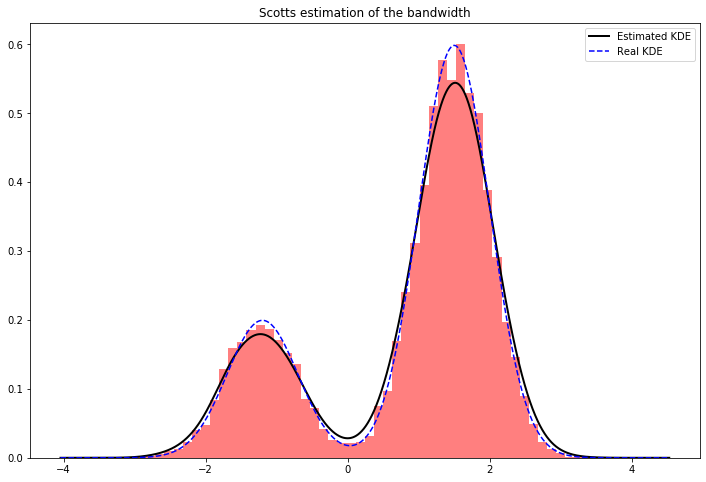

In [6]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.hist(obs_dist1, bins=50, density=True, color='red', alpha=.5)
ax.plot(xs, ys, lw=2, color='black', label='Estimated KDE')
ax.plot(xs, mix.pdf(xs, **dist1), color='blue', linestyle='--', label='Real KDE')
plt.legend(loc='best')
ax.set_title('Scotts estimation of the bandwidth')

It is clear here that the bandwidth is too large, which is to be expected given the Scotts method assumes the data follows a normal distribution. For a better estimate, we will use cross-validation. The basics cross-validation technique involve the so-called 'leave one out' method, where each data point is, in turn, removed from the dataset to estimate the quantity to minimise. This is really slow! So we will use another, approximated but much faster, folding method:

In [7]:
kde.bandwidth = bandwidths.CrossValidation(use_grid=True, folding=10)
mod2 = kde.fit()
mod2.bandwidth

0.10372038595127911

In [8]:
xs2, ys2 = mod2.grid()

Text(0.5, 1.0, 'Cross-validation estimation of the bandwidth')

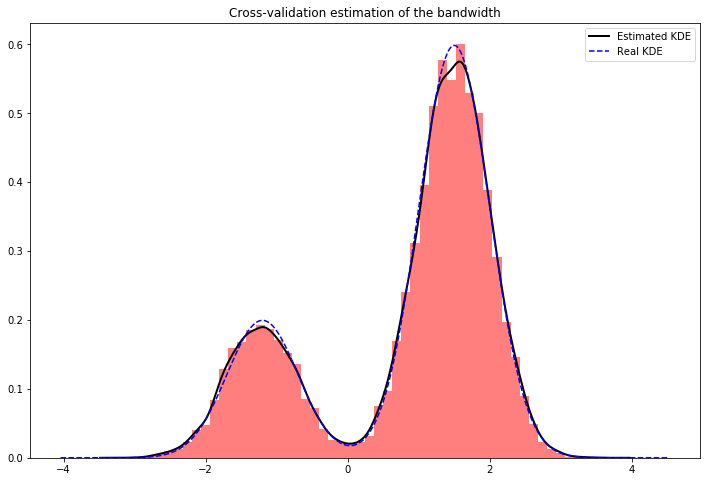

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.hist(obs_dist1, bins=50, density=True, color='red', alpha=.5)
ax.plot(xs2, ys2, lw=2, color='black', label='Estimated KDE')
ax.plot(xs, mix.pdf(xs, **dist1), color='blue', linestyle='--', label='Real KDE')
plt.legend(loc='best')
ax.set_title('Cross-validation estimation of the bandwidth')

## Multivariate example

In [10]:
import statsmodels.sandbox.distributions.mv_normal as mvd
cov1 = np.diag([1,.2])
cov2 = np.diag([.5,1.1])
mu1 = np.array([1, -2.5])
mu2 = np.array([-2, 1])
mvn1 = mvd.MVNormal(mu1, cov1)
mvn2 = mvd.MVNormal(mu2, cov2)

In [11]:
rvs = mv_mixture_rvs([.6, .4], 10000, [mvn1, mvn2], 2)

def dist_pdf(x):
    return 0.6*mvn1.pdf(x) + 0.4*mvn2.pdf(x)

rvs.shape

(10000, 2)

In [12]:
bounds = [[-5,6],[-5,6]]

In [13]:
grid, values = fast_linbin.fast_bin_nd(rvs, bounds, 128)
values /= grid.start_volume * rvs.shape[0]
grid

<Grid 128Bx128B, [-5 - 6 ; -5 - 6], dtype=float64>

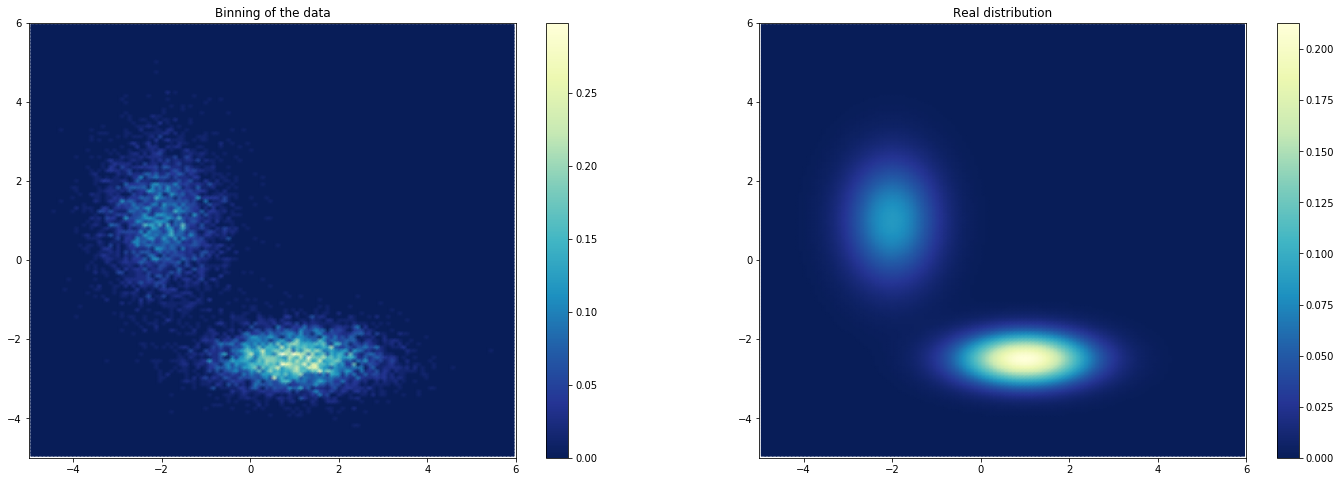

In [14]:
fig = plt.figure(figsize=(24, 8))
m2 = grid.full('C')
ax = fig.add_subplot(1,2,1)
m = ax.pcolormesh(m2[0], m2[1], values, cmap=plt.cm.YlGnBu_r, shading='gouraud')
ax.set_xlim(*bounds[0])
ax.set_ylim(*bounds[1])
ax.set_title('Binning of the data')
plt.colorbar(ax=ax, mappable=m)

ax = fig.add_subplot(1,2,2)
real_pdf = dist_pdf(grid.linear()).reshape(grid.shape)
m = ax.pcolormesh(m2[0], m2[1], real_pdf, cmap=plt.cm.YlGnBu_r, shading='gouraud')
ax.set_xlim(*bounds[0])
ax.set_ylim(*bounds[1])
ax.set_title('Real distribution')
plt.colorbar(ax=ax, mappable=m)

In [15]:
kde = sm.kernel_methods.KDE(rvs)
mod = kde.fit()
xs, ys = mod.grid()
mod.bandwidth

array([0.29029204, 0.31441185])

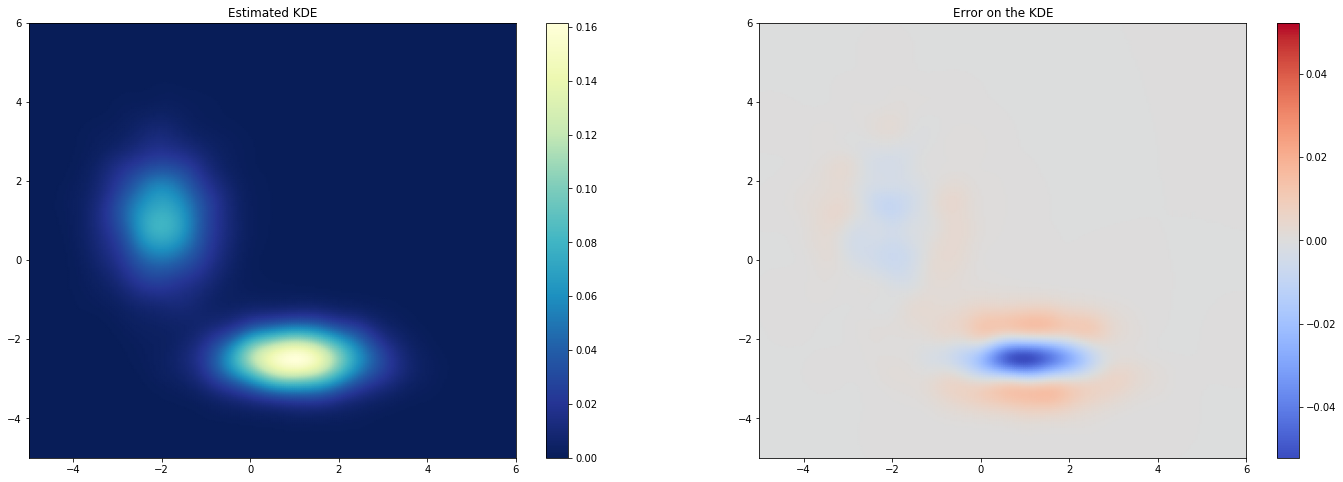

In [16]:
fig = plt.figure(figsize=(24, 8))
m2 = xs.full('C')
ax = fig.add_subplot(1,2,1)
m = ax.pcolormesh(m2[0], m2[1], ys, cmap=plt.cm.YlGnBu_r, shading='gouraud')
ax.set_xlim(*bounds[0])
ax.set_ylim(*bounds[1])
ax.set_title('Estimated KDE')
plt.colorbar(ax=ax, mappable=m)

ax = fig.add_subplot(1,2,2)
real_pdf = dist_pdf(xs.linear()).reshape(xs.shape)
m = ax.pcolormesh(m2[0], m2[1], (ys-real_pdf), cmap=plt.cm.coolwarm, shading='gouraud')
cmin, cmax = m.get_clim()
crange = max(abs(cmin), abs(cmax))
m.set_clim(-crange, crange)
ax.set_xlim(*bounds[0])
ax.set_ylim(*bounds[1])
ax.set_title('Error on the KDE')
plt.colorbar(ax=ax, mappable=m)

In [17]:
kde.bandwidth = bandwidths.CrossValidation(use_grid=True, folding=7)
mod2 = kde.fit()
xs2, ys2 = mod2.grid()
mod2.bandwidth

array([0.26639422, 0.14548464])

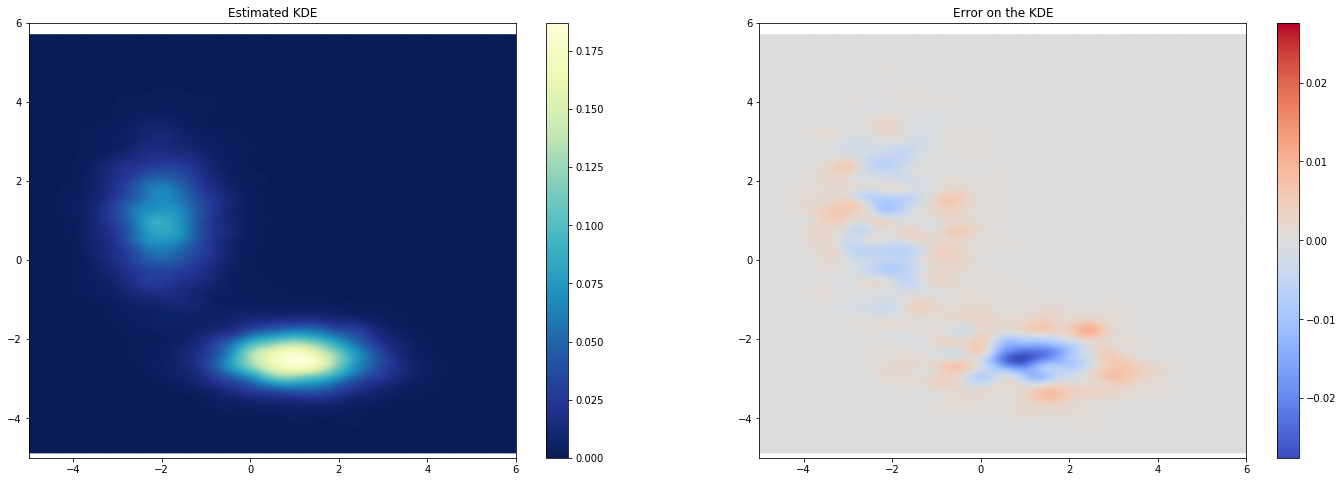

In [18]:
fig = plt.figure(figsize=(24, 8))
m2 = xs2.full('C')
ax = fig.add_subplot(1,2,1)
m = ax.pcolormesh(m2[0], m2[1], ys2, cmap=plt.cm.YlGnBu_r, shading='gouraud')
ax.set_xlim(*bounds[0])
ax.set_ylim(*bounds[1])
ax.set_title('Estimated KDE')
plt.colorbar(ax=ax, mappable=m)

ax = fig.add_subplot(1,2,2)
real_pdf = dist_pdf(xs2.linear()).reshape(xs.shape)
m = ax.pcolormesh(m2[0], m2[1], (ys2-real_pdf), cmap=plt.cm.coolwarm, shading='gouraud')
cmin, cmax = m.get_clim()
crange = max(abs(cmin), abs(cmax))
m.set_clim(-crange, crange)
ax.set_xlim(*bounds[0])
ax.set_ylim(*bounds[1])
ax.set_title('Error on the KDE')
plt.colorbar(ax=ax, mappable=m)

In the end, you can observe we get a much better approximation of the bottom peak (the max error is about half).